## Automated portfolio system
#### Uses an alpha generator to make a portfolio.
#### An alpha generator is any security that, when added by an investor to an existing portfolio of assets, generates excess returns or returns higher than a pre-selected benchmark without additional risk.
#### I am using the price momentum alpha generator because its calculations are free and easily accessible through yfinance library.

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


C:\Users\jeanb\AppData\Local\Temp\ipykernel_5740\2988629714.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### The SP500 is our benchmark, we retrieve its updated 500 stocks directly from the daily-updated csv from the State Street Global Advisors website.

In [2]:
# Get the list of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  504 of 504 completed

3 Failed downloads:
['-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [3]:
# Gets the last date of dataset
# This is our most current price for eah asset, just as a refernce of the prices we are using.
sp500.tail(1) 

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-19,146.955002,13.9499,175.914993,178.720001,163.039993,113.610001,91.75,377.0,519.080017,190.315002,...,34.32,99.459999,52.255001,113.1791,33.060001,128.085007,136.630005,125.989998,285.804993,172.75


In [4]:
# Changing the time period and lag will affect the range of the alortithm
time_period = 1260  # 5 years of trading days. (252 trading days per year)
lag = 20 # lag of 20 trading days (1 month)


## Momentum Factors
####  Takes 5 factors: Slope 52 Week Trend-Line, Percent above 260 Day Low, 4/52 Week Oscillator, 39_Week_Return, 51 Week Volume Price Trend
#### This cell box will
#### 1. Perform the calculations for each of these factors.
#### 2. Normalize the calculations using Z-Score.
#### 3. Group the calculations together to create a score for each stock in SP500
#### 4. Take the highest scores and sort those into a Long-basket (Predicited Strong Growth)
#### 5. Put the lowest scores into a Short-basket (Predicited Very Low Growth)


 #### The function uses how many days back as a range. 
 #### The most current up to date calculation will require 0 days back.

 #### Checking how the algorithm woulve ran 5 years ago, would require you to set how many days back to the value of 5 years.
 #### (We use this to check the validity of the program,measuring how well the basket chose 5 years ago performed determines if the model works)

In [5]:
#how_many_days_back = 0 for current, 1260 for 5 years.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) # This is our first factor, the 52 week trend line which is the average of the slopes of the 52 week trend line


    # percent above 260 day low is the current price - 260 day low / 260 day low * 100, its used to measure the strength of the current price
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100, the oscillator is a measure of momentum
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors (5 years prior to current date) (20 day lag)

Aggregate factors with z-score calculation. Z-scores will determine the long basket and short basket.

In [6]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
Ticker,,,,,
A,0.048455,38.167258,6.328893,0.128746,1.218564e+05
AAL,-0.015124,44.897210,-6.925349,-0.043598,9.201541e+07
AAPL,0.125744,57.127582,14.185972,0.300897,3.023787e+07
ABBV,0.081186,39.065473,10.047560,0.183001,-7.650193e+05
ABNB,NaN,35.558008,-4.316139,-0.025335,1.636902e+06
...,...,...,...,...,...
XYL,0.027316,40.654384,4.409870,0.098719,-3.297153e+05
YUM,0.029267,36.229600,3.431978,0.067370,5.059287e+04
ZBH,0.001205,32.985000,-0.723083,0.021644,-1.078148e+05


In [7]:
# Path
excel_file_path = 'resources/momentum_factors.xlsx'

# Save the DataFrame to Excel
momentum_factors.to_excel(excel_file_path, index=True)

In [8]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
Ticker
TSLA    40.546842
MRNA    18.795290
NVDA    17.723874
SMCI    15.577978
NVR     15.025590
ENPH    14.466303
BLDR     9.569182
CMG      9.525999
AZO      9.104586
AMD      9.097516
dtype: float64

Short Basket:
Ticker
VZ     -4.952083
T      -4.976821
PARA   -5.206803
WBA    -5.353439
ILMN   -5.507334
VTRS   -5.643142
WBD    -5.953761
BAX    -6.113406
FIS    -6.225328
VFC    -7.708280
dtype: float64


## Creating the Back-Tested Baskets

In [9]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Long Basket Past 5 Years:
Ticker
NVR     18.601219
NVDA    16.931581
AMD     16.357942
ETSY    13.551080
CZR     13.175108
NFLX    12.494395
ALGN    11.289887
PAYC    11.054839
ENPH     8.401169
AMZN     8.155108
dtype: float64
Short Basket Past 5 Years:
Ticker
F      -5.051092
BEN    -5.160989
HWM    -5.228878
BBWI   -5.329688
APA    -5.405929
CMG    -5.409216
SLB    -5.701559
MCK    -5.720278
EQT    -6.478611
GE     -6.801560
dtype: float64


## Cumulative Returns

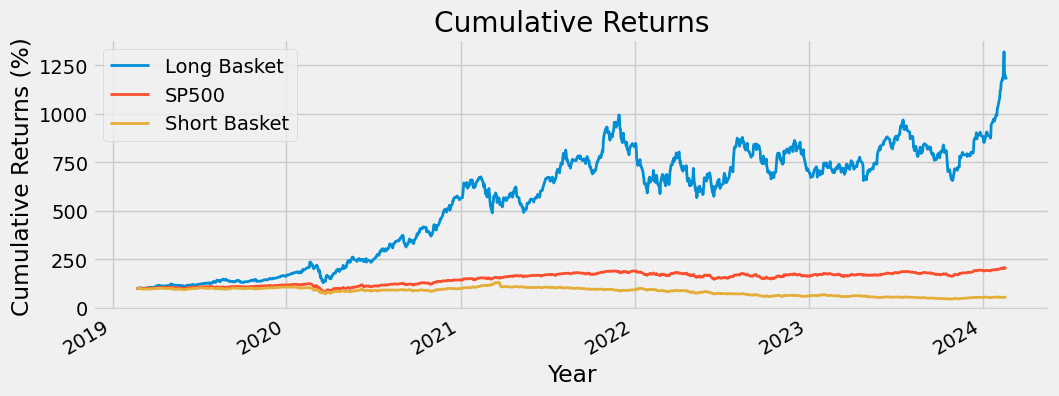

In [10]:
def calculate_cumulative_returns(dataf): 
    returns = dataf.pct_change()
    cumulative_returns = (1 + returns).cumprod().mean(axis=1)*100
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns.plot(label='SP500', lw =2)
short_cumulative_returns.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

# Back Tested Cumulative Returns

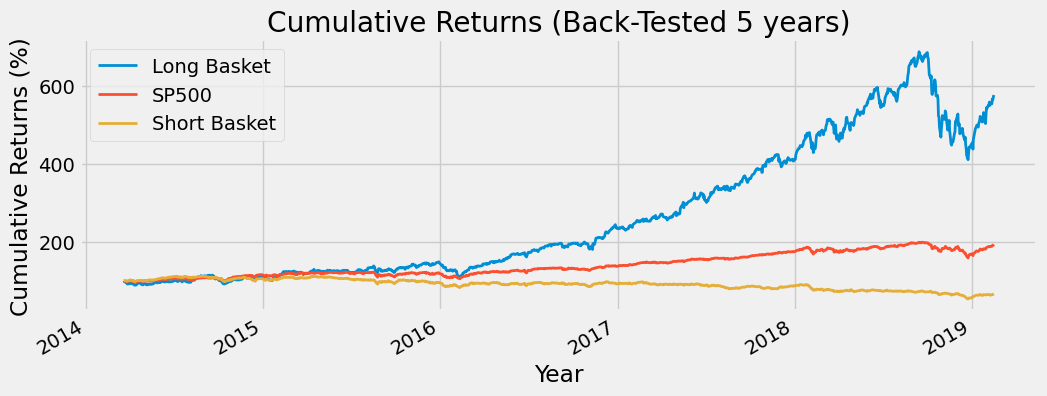

In [11]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns (Back-Tested 5 years)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

# As of most current day:

In [12]:
print("Long Basket Cumulative Returns: Most current day")
print(long_cumulative_returns[-1])
print("Short Basket Cumulative Returns: Most current day")
print(short_cumulative_returns[-1])
print("SP500 Cumulative Returns: Most current day")
print(cumulative_returns[-1])

Long Basket Cumulative Returns: Most current day
1178.0587315294688
Short Basket Cumulative Returns: Most current day
54.33226290883242
SP500 Cumulative Returns: Most current day
203.54956084161984


In [13]:
current_date = datetime.now().strftime("%Y-%m-%d")
print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


As of 2024-03-19 Long Basket has outperformed the SP500 by 974.509170687849 percentage points
As of 2024-03-19 Short Basket has underperformed the SP500 by -149.2172979327874 percentage points


## Monthly Potfolio Returns

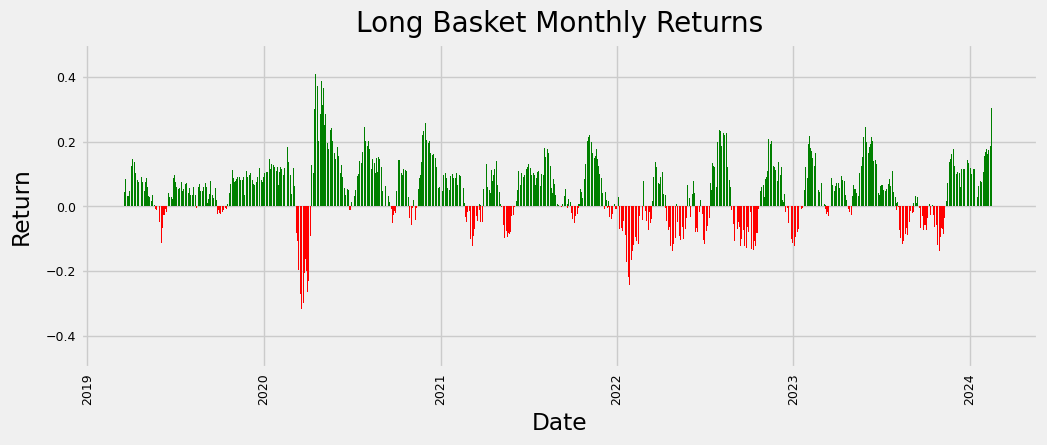

In [14]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

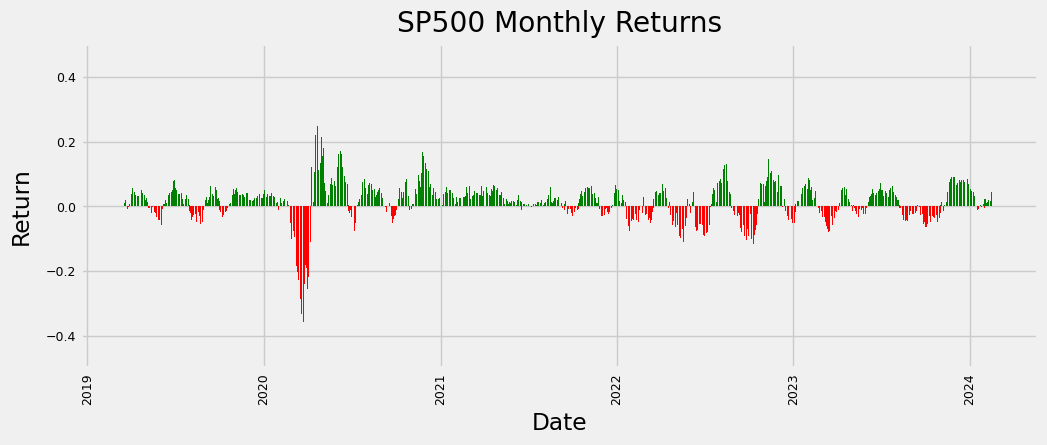

In [15]:
# Calculate 20-day returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

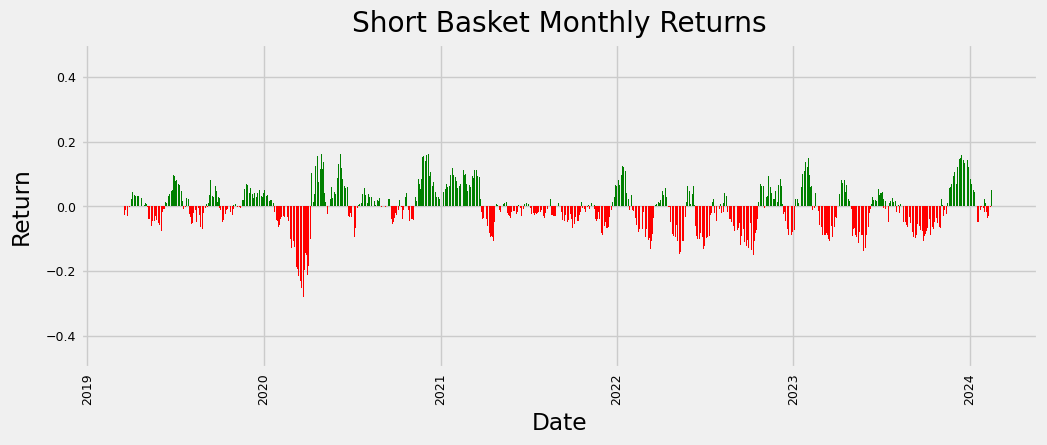

In [16]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Portfolio weights : 
#### My Efficient Frontier Program takes a basket of stocks and simulates over 200,000 times to find the arrangement of stock weights for our portfolio, that will return the highest earnings over risk-level.
#### You can find this program in the directory labeled Efficient_Frontier


# Portfolio weights
## Imported class from Efficient Frontier notebook
### It runs a monte-carlo simulation to find the optimal weight based on a high return to risk ratio.

In [17]:
%%capture 
import os
import sys

# Getting the directory for the efficient frontier module: 
current_dir = os.getcwd()[:-14] # slicing out the last 14 characters (current directory)

target_dir = current_dir + 'Efficient-Frontier'

# Add the directory containing the module to the Python path
sys.path.insert(0, target_dir)

from Efficient_Frontier import EfficientFrontier

"""
Im using %%capture to suppress the output of the cell.
"""

In [18]:
ef = EfficientFrontier(sp500[long_basket.index])
print('Annual Returns: Long Basket')
ef.calculate_portfolio() #Printing Annual Returns

Annual Returns: Long Basket
Ticker
TSLA    1.389251
MRNA    1.594901
NVDA    1.636598
SMCI    1.558487
NVR     1.234611
ENPH    1.579031
BLDR    1.444413
CMG     1.211516
AZO     1.209159
AMD     1.545029
dtype: float64


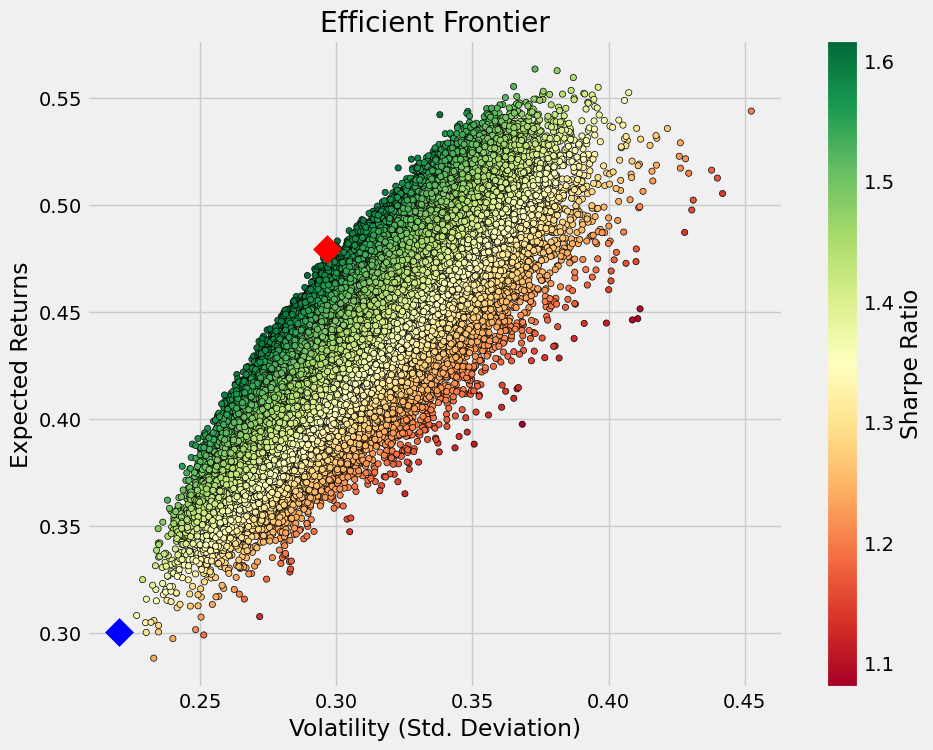

In [19]:
ef.plot_frontier() # Visualizes the simulations for our Long Basket portfolio
# With each dot representing a different portfolio, and the curve of the spread representing the efficient frontier

In [20]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.300316                  0.479480
Volatility                        0.220031                  0.296453
Sharpe Ratio                      1.364879                  1.617391
TSLA Weight                       0.051118                  0.013270
MRNA Weight                       0.101076                  0.155588
NVDA Weight                       0.032128                  0.250389
SMCI Weight                       0.010970                  0.150165
NVR Weight                        0.293823                  0.022550
ENPH Weight                       0.004250                  0.073423
BLDR Weight                       0.002243                  0.019092
CMG Weight                        0.080609                  0.022661
AZO Weight                        0.377251                  0.244763
AMD Weight                        0.046532                  0.048099
